In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import re
import bz2
import os
import nltk
nltk.download('punkt')
data_dir = "./data"
print(os.listdir(data_dir))

from model import DialogueRNNCell
from utils import pad_input, preprocessData, normalizeSentences
from train_test import train_model, test_model

['cnn2_state_dict.pt', 'cnn_state_dict.pt', 'idx2word.npy', 'lstm_state_dict.pt', 'model_state_dict.pt', 'test.ft.txt.bz2', 'testerDRNN_model_state_dict.pt', 'test_data.npy', 'test_labels.npy', 'test_model_state_dict.pt', 'train.ft.txt.bz2', 'train_data.npy', 'train_labels.npy', 'val_data.npy', 'val_labels.npy', 'word2idx.npy']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prajw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
num_train = 80000 # Number of train samples to include
num_test = 20000 # Number of test samples to include
seq_len = 200 #The length that the sentences will be padded/shortened to
batch_size = 400 # How many samples to process in one iteration
test_val_split = 0.75 # Percentage of train data are split into validation
      
load = all(npy_file in os.listdir(data_dir) for npy_file in ["train_data.npy", "train_labels.npy", 
                                                         "test_data.npy", "test_labels.npy", 
                                                         "val_data.npy", "val_labels.npy"])

if load:
    print("Loading files ...")
    train_sentences = np.load(data_dir + "/train_data.npy", allow_pickle=True)
    train_labels = np.load(data_dir + "/train_labels.npy", allow_pickle=True)
    test_sentences = np.load(data_dir + "/test_data.npy", allow_pickle=True)
    test_labels = np.load(data_dir + "/test_labels.npy", allow_pickle=True)
    val_sentences = np.load(data_dir + "/val_data.npy", allow_pickle=True)
    val_labels = np.load(data_dir + "/val_labels.npy", allow_pickle=True)
    print("Files done loading")
else:
    train_file = bz2.BZ2File(data_dir +'/train.ft.txt.bz2', 'r')
    test_file = bz2.BZ2File(data_dir + '/test.ft.txt.bz2', 'r')
    train_file_lines = train_file.readlines()
    test_file_lines = test_file.readlines()
    train_sentences, test_sentences, train_labels, test_labels, word2idx, idx2word = preprocessData(train_file_lines, test_file_lines, num_train, num_test, seq_len)
    train_sentences, test_sentences = normalizeSentences(train_sentences, test_sentences, word2idx, seq_len)
    val_sentences, train_sentences, val_labels, train_labels = train_test_split(train_sentences, train_labels, test_size=test_val_split, shuffle=True)

    print("Saving files ...")
    np.save(data_dir + "/train_data.npy", train_sentences)
    np.save(data_dir + "/train_labels.npy", train_labels)
    np.save(data_dir + "/test_data.npy", test_sentences)
    np.save(data_dir + "/test_labels.npy", test_labels)
    np.save(data_dir + "/val_data.npy", val_sentences)
    np.save(data_dir + "/val_labels.npy", val_labels)
    print("Files done saving")

Loading files ...
Files done loading


In [4]:
train_data = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels).float())
test_data = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(test_labels).float())
val_data = TensorDataset(torch.from_numpy(val_sentences), torch.from_numpy(val_labels).float())

train_subset = torch.utils.data.Subset(train_data, range(num_train))
test_subset = torch.utils.data.Subset(test_data, range(num_test))
val_subset = torch.utils.data.Subset(val_data, range(int(num_train * (1-test_val_split))))
train_loader = DataLoader(train_subset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_subset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_subset, shuffle=True, batch_size=batch_size)

In [5]:
# framework for this model is very similar to the DialogueRNN model in the model.py class
class NoPartyDialogueRNN(nn.Module):

    def __init__(self, D_m, D_g, D_p, D_e, hidden_layer, output_size, vocab_size, sequence_length, dropout, device):
        super(NoPartyDialogueRNN, self).__init__()

        self.D_m = D_m
        self.D_g = D_g
        self.D_p = D_p
        self.D_e = D_e
        self.sequence_length = sequence_length

        self.embedding = nn.Embedding(vocab_size, D_m)
        self.dialogue_cell = DialogueRNNCell(D_m, D_g, D_p, D_e, dropout)
        self.dropout = nn.Dropout(dropout+0.15)
        self.classify = nn.Sequential(
            nn.Linear(D_e*sequence_length, hidden_layer),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_layer, output_size)
        )
        self.sigmoid = nn.Sigmoid()
        self.device = device

    def forward(self, sentences):
        """
        sentences -> batch, seq_len
        """

        embeds = self.embedding(torch.transpose(sentences, 0, 1)) # seq_len, batch, D_m
        
        qmask = torch.ones((sentences.size()[0], 1)).to(self.device) # batch, party -> there is only 1 party for these sentences
        g_hist = torch.zeros((1, sentences.size()[0], self.D_g)).type(torch.FloatTensor).to(self.device) # s-1, batch, D_g, starts with s=1 where s represents the number of splits 
        q_ = torch.zeros(sentences.size()[0], 1, self.D_p).type(torch.FloatTensor).to(self.device) # batch, party, D_p
        e_ = torch.zeros((sentences.size()[0], self.D_e)).type(torch.FloatTensor).to(self.device) # batch, D_e
        emotions = []

        # run rnn cell for each segment of size D_m
        for i in range(embeds.size()[0]):
            utterance = embeds[i, :, :] # utterance is batch, D_m
            g_, q_, e_, attention_ = self.dialogue_cell(utterance, qmask, g_hist, q_, e_)
            if i == 0:
              emotions = e_
            else:
              emotions = torch.cat([emotions, e_],1)
            g_hist = torch.cat([g_hist, g_.unsqueeze(0)],0)

        emotions = self.dropout(emotions) # emotions -> batch, D_e*seq_len
        final_emotion = self.classify(emotions) # final_emotion -> batch, output_size
        final_emotion = self.sigmoid(final_emotion)
        return final_emotion

In [6]:
#################### Model Parameters #################################
D_m = 50 # Size of text embedding 
D_g = 120 # Size of global state
D_p = 100 # size of party state vector (simulating only 1 party fills vector with 1s)
D_e = 75 # Size of emotion vector and output from DialogueRNNCell
hidden_layer = 128 # Size of hidden layer after first dropout
output_size = 1 # Final output size
dropout = 0.3
vocab_size = 225965
full_review_len = seq_len # Full length of padded review string
#######################################################################

#################### Optimizer Parameters #################################
learning_rate = 0.005
epochs = 1
#######################################################################

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

model_state = data_dir + "/model_state_dict.pt"
loss_function = nn.BCELoss()
NPDN = NoPartyDialogueRNN(D_m, D_g, D_p, D_e, hidden_layer, output_size, vocab_size, full_review_len, dropout, device).to(device)
print(NPDN)
optimizer = optim.Adam(NPDN.parameters(), lr=learning_rate)

Epoch: 1/1... Step: 50... Loss: 1.219624... Val Loss: 0.693335
Validation loss decreased (inf --> 0.693335).  Saving model ...
Epoch: 1/1... Step: 100... Loss: 0.693161... Val Loss: 0.693263
Validation loss decreased (0.693335 --> 0.693191).  Saving model ...
Epoch: 1/1... Step: 150... Loss: 1.215099... Val Loss: 0.693222
Validation loss decreased (0.693191 --> 0.693140).  Saving model ...
Epoch: 1/1... Step: 200... Loss: 0.694161... Val Loss: 0.693160
Validation loss decreased (0.693140 --> 0.692975).  Saving model ...


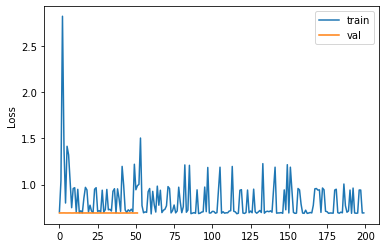

In [ ]:
train_model(NPDN, loss_function, optimizer, epochs, device, train_loader, val_loader, model_state)

In [7]:
test_model(NPDN, loss_function, device, test_loader, model_state)

Test loss: 0.693
Test accuracy: 50.193%
